# Gathering of Bayesian evidence for the ELM model

In [59]:
import pickle
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from periodictable import elements

import elm

In [2]:
import exfor_tools
import jitr

In [102]:
# plotting
kd_color = "#bc5090"
qelm_color = "#f28d3d"
elm_color = "#4277c0"

In [3]:
proton = (1, 1)
neutron = (1, 0)

In [4]:
Ca40 = (40, 20)
Ca48 = (48, 20)

Zr90 = (90, 40)
Zr92 = (92, 40)
Zr94 = (94, 40)
Zr96 = (96, 40)

Sn124 = (124, 50)
Sn122 = (122, 50)
Sn120 = (120, 50)
Sn118 = (118, 50)
Sn116 = (116, 50)

Ba138 = (138, 56)

Ce140 = (140, 58)

Sm144 = (144, 62)
Sm148 = (148, 62)

Pb208 = (208, 82)
Pb206 = (206, 82)

In [5]:
targets = [
    Ca40,
    Ca48,
    Zr90,
    Zr92,
    Zr94,
    Zr96,
    Sn116,
    Sn118,
    Sn120,
    Sn122,
    Sn124,
    Ba138,
    Ce140,
    Sm144,
    Sm148,
    Pb206,
    Pb208,
]

In [6]:
for t in targets:
    A, Z = t
    n_data_path = Path(f"./{elements[Z]}{A}_n_elastic.pkl")
    if n_data_path.is_file():
        with open(n_data_path, "rb") as f:
            entries = pickle.load(f)
            n_entries = len(entries)
            n_measurements = np.sum(
                [len(entry.measurements) for entry in entries.values()]
            )
        print(
            f"Read {n_measurements} measurements from {n_entries} entries from {n_data_path}"
        )
    p_data_path = Path(f"./{elements[Z]}{A}_p_elastic.pkl")
    if p_data_path.is_file():
        with open(p_data_path, "rb") as f:
            entries = pickle.load(f)
            n_entries = len(entries["xs"]) + len(entries["ratio"])
            n_measurements = np.sum(
                [len(entry.measurements) for entry in entries["xs"].values()]
            ) + np.sum([len(entry.measurements) for entry in entries["ratio"].values()])
        print(
            f"Read {n_measurements} measurements from {n_entries} entries from {p_data_path}"
        )

Read 12 measurements from 3 entries from Ca40_n_elastic.pkl
Read 46 measurements from 25 entries from Ca40_p_elastic.pkl
Read 2 measurements from 1 entries from Ca48_n_elastic.pkl
Read 15 measurements from 7 entries from Ca48_p_elastic.pkl
Read 3 measurements from 2 entries from Zr90_n_elastic.pkl
Read 23 measurements from 21 entries from Zr90_p_elastic.pkl
Read 2 measurements from 1 entries from Zr92_n_elastic.pkl
Read 9 measurements from 9 entries from Zr92_p_elastic.pkl
Read 2 measurements from 1 entries from Zr94_n_elastic.pkl
Read 5 measurements from 5 entries from Zr94_p_elastic.pkl
Read 2 measurements from 2 entries from Zr96_p_elastic.pkl
Read 3 measurements from 2 entries from Sn116_n_elastic.pkl
Read 7 measurements from 7 entries from Sn116_p_elastic.pkl
Read 2 measurements from 1 entries from Sn118_n_elastic.pkl
Read 1.0 measurements from 1 entries from Sn118_p_elastic.pkl
Read 3 measurements from 2 entries from Sn120_n_elastic.pkl
Read 13 measurements from 12 entries from S

In [172]:
A, Z =116, 50
n_data_path = Path(f"./{elements[Z]}{A}_n_elastic.pkl")
n_data_path.is_file()

True

In [173]:
core_solver = jitr.rmatrix.Solver(40)
channel_radius = 10 * np.pi
lmax = 20
theta_vis = np.linspace(0.1, np.pi, 180)

In [174]:
def set_up_n_elastic_workspaces(target):
    n_data_path = Path(f"./{elements[Z]}{A}_n_elastic.pkl")
    if not n_data_path.is_file():
        return
    with open(n_data_path, "rb") as f:
        entries = pickle.load(f)

    measurements = exfor_tools.sort_measurements_by_energy(entries)

    return [
        elm.DifferentialXS(
            neutron, target, m.Elab, m, theta_vis, core_solver, channel_radius, lmax
        )
        for m in measurements
    ]

In [175]:
import json

param_file = Path("/home/beyerk/Projects/jitr/src/data/KD_default.json")
kduq_omp_neutron = jitr.reactions.kduq.KDGlobal(neutron, param_file)

In [176]:
workspaces = set_up_n_elastic_workspaces((A,Z))

In [177]:
len(workspaces)

3

(-20.0, 185.0)

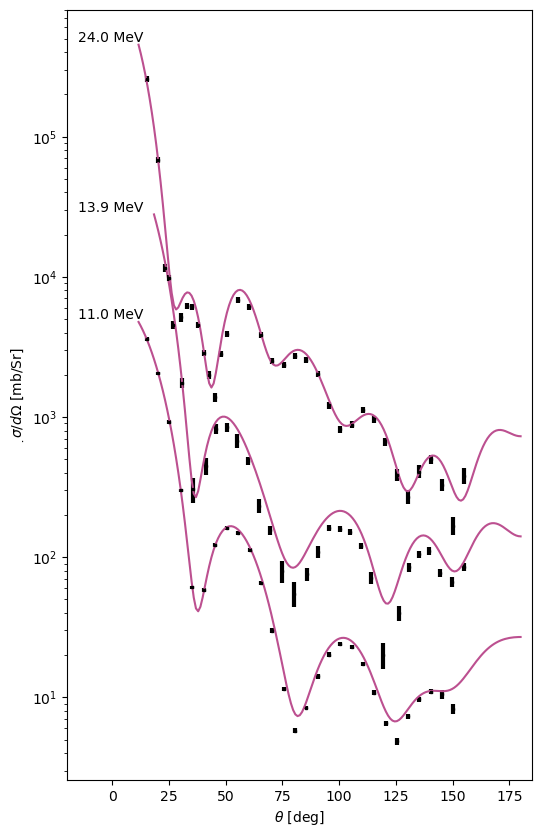

In [178]:
fig, ax = plt.subplots(figsize=(6, 10))
for i in range(len(workspaces)):
    offset = 10 ** (i)
    coulomb_params, scalar_params, spin_orbit_params = kduq_omp_neutron.get_params(
        *workspaces[i].calibration_model.target,
        workspaces[i].calibration_model.mu,
        workspaces[i].exp.Elab,
        workspaces[i].calibration_model.k,
    )

    xs_sample = workspaces[i].visualization_model.xs(
        jitr.reactions.kduq.KD_scalar,
        jitr.reactions.kduq.KD_spin_orbit,
        scalar_params,
        spin_orbit_params,
    )
    x, dx, y, dy = workspaces[i].exp.data
    
    plt.errorbar(
        x,
        y * offset,
        yerr=dy *offset,
        linestyle="none",
        elinewidth=3,
        marker="s",
        markersize=2,
        color='k'
    )

    xth = workspaces[i].angles_vis * 180 / np.pi
    yth = xs_sample.dsdo 
    mask = np.logical_and(xth >= x[0]*0.75, xth <= x[-1] * 1.25 )
    
    plt.plot( xth[mask], yth[mask] * offset, color=kd_color)
    
    if x[-1] < 25:
        xloc = 35
        yloc = yth[mask][-1]
    
    elif x[-1] < 35:
        xloc = 45
        yloc = yth[mask][-1]

    elif x[-1] < 50:
        xloc = 60
        yloc = yth[mask][-1]
    elif x[-1] < 100:
        xloc = 110
        yloc = yth[mask][-1]

    elif x[0] > 5:
        xloc = -15
        yloc = yth[mask][0] * 1.05

    else:
        xloc = 160
        yloc = yth[mask][-1]

    plt.text( xloc, yloc * offset, f"{workspaces[i].exp.Elab:.1f} MeV")

plt.yscale("log")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\d\sigma/d\Omega$ [mb/Sr]")
#plt.ylim([10, 1e6])
plt.xlim([-20,185])